# Import Libraries and Data

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import re

import numpy as np
from functools import reduce
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn import svm
import torch
import torch.nn as nn
from tqdm import tqdm
import warnings

from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

In [56]:
DATA_PATH = '../data'
MODEL_PATH = '../src/models'

In [57]:
feature_matrix = pd.read_csv(f'{DATA_PATH}/processed/feature_matrix.csv')
feature_matrix.head()

,FPF_TARGET,minbalance,maxbalance,stdbalance,total_balance,avg_monthly_spending,num_monthly_purchase,memo_clean,unsufficient_balance,account_count,...,OVERDRAFT_prop,PAYCHECK_prop,PETS_prop,RENT_prop,SELF_TRANSFER_prop,TAX_prop,TRAVEL_prop,UNCATEGORIZED_prop,Overdraft Count,cum_weighted_def_val
0,0.0,0.52,253.01,125.590741,857.150161,5531.648836,79.521124,2.0,5,5,...,0.000000,0.0,0.000498,0.0,0.142151,0.000000,0.000830,0.089842,0.0,0.000000
1,0.0,6.11,31564.64,13215.093678,43016.714011,64529.528960,160.211203,0.0,4,4,...,0.000000,0.0,0.000000,0.0,0.016751,0.001093,0.004267,0.246412,0.0,0.000000
2,0.0,1092.82,31229.66,17278.364208,14667.666944,16997.552350,92.855324,0.0,3,3,...,0.000000,0.0,0.000000,0.0,0.261025,0.000000,0.002219,0.001825,0.0,0.000000
3,0.0,40.45,6425.61,4514.989935,-4188.933058,9778.291345,95.104454,0.0,2,2,...,0.000000,0.0,0.011885,0.0,0.000000,0.000000,0.000142,0.016086,0.0,0.000000
4,0.0,0.40,1009.99,438.528721,-2630.480387,16837.676865,119.566068,0.0,4,4,...,0.057938,0.0,0.001095,0.0,0.000000,0.000000,0.016481,0.140562,1.0,318.890041


## Final Feature Matrix

In [58]:
# Train Test Split
TEST_SIZE = 0.2
X = feature_matrix.iloc[:,1:].to_numpy()
y = feature_matrix.iloc[:,0].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size = TEST_SIZE, 
    random_state=42
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, 
    y_train, 
    test_size = TEST_SIZE, 
    random_state=42
)

# Prototype Model to Predict Default Risk

### Training

In [59]:
lin_model = linear_model.LogisticRegression()

In [60]:
lin_model.fit(X_train, y_train)

/Users/darrenjiang/opt/anaconda3/envs/dsc180/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

### Evaluate Model

In [61]:
valid_pred = lin_model.predict(X_valid)
test_pred = lin_model.predict(X_test)

In [62]:
def get_metrics(pred, actual, display=True):
    cm = confusion_matrix(actual, pred)
    tn, fp, fn, tp = cm.ravel()

    TPR = tp / (tp + fn)
    FPR = tn / (tn + fp)
    roc_auc = roc_auc_score(actual, pred)
    if (display):
        print(f"Accuracy: {np.mean(pred == actual):.4f}")
        print(f"tn:  {tn},  fp:  {fp},  fn:  {fn}, tp:  {tp}")
        print(f"Precision:\t\t\t{tp / (tp + fp):.5f}")
        print(f"Recall:\t\t\t\t{tp / (tp + fn):.5f}")
        print(f"TPR:\t\t\t\t{TPR:.5f}")
        print(f"FPR:\t\t\t\t{FPR:.5f}")
        print(f"Positive likelihood ratio:\t{TPR/FPR:.5f}")
        print(f"Negative likelihood ratio:\t{FPR/TPR:.5f}")
        print(f"ROC-AUC Score:\t{roc_auc:.5f}")
        return
    return [tn, fp, fn, tp, TPR, FPR, TPR/FPR, FPR/TPR, roc_auc]

In [63]:
print("Validation:")
get_metrics(valid_pred, y_valid)
print("===========================")
print("Test:")
get_metrics(test_pred, y_test)

Validation:
Accuracy: 0.7987
tn:  354,  fp:  21,  fn:  75, tp:  27
Precision:			0.56250
Recall:				0.26471
TPR:				0.26471
FPR:				0.94400
Positive likelihood ratio:	0.28041
Negative likelihood ratio:	3.56622
ROC-AUC Score:	0.60435
Test:
Accuracy: 0.8154
tn:  462,  fp:  36,  fn:  74, tp:  24
Precision:			0.40000
Recall:				0.24490
TPR:				0.24490
FPR:				0.92771
Positive likelihood ratio:	0.26398
Negative likelihood ratio:	3.78815
ROC-AUC Score:	0.58630


# Prototype 2: Basic Sequential NN

### Define Model

In [64]:
# Define the model
model = nn.Sequential(
    nn.Linear(X.shape[1], 12),
    nn.ReLU(),
    nn.Linear(12, 24),
    nn.ReLU(),
    nn.Linear(24, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1),
    nn.Sigmoid()
)

In [65]:
# loss function and optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

### Training

In [66]:
# training parameters
n_epochs = 200   # number of epochs to run
batch_size = 16  # size of each batch

In [67]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.float32).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

In [73]:
def train_SNN(
        model, 
        loss_fn, 
        optimizer, 
        X_train_tensor, 
        y_train_tensor, 
        X_valid_tensor, 
        y_valid_tensor, 
        n_epochs=n_epochs,
        batch_size=batch_size, 
        display=True):
    
    batch_start = torch.arange(0, X_train_tensor.shape[0], batch_size)
    train_history = []
    valid_history = []
    best_valid = np.inf
    
    # training loop
    bar = tqdm(range(n_epochs))
    for epoch in bar:
        model.train()
        bar.set_description(f"Epoch {epoch+1}")
        for start in batch_start:
            # take a batch
            X_batch = X_train_tensor[start:start+batch_size]
            y_batch = y_train_tensor[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred_train = model(X_train_tensor)
        y_pred_valid = model(X_valid_tensor)
        train_loss = float(loss_fn(y_pred_train, y_train_tensor))
        valid_loss = float(loss_fn(y_pred_valid, y_valid_tensor))
        
        bar.set_postfix(Train_MSE = float(train_loss), Valid_MSE = float(valid_loss))
        train_history.append(train_loss)
        valid_history.append(valid_loss)

        if (valid_loss < best_valid):
            torch.save(model.state_dict(), f'{MODEL_PATH}/nn_base_params.pt')

    if display:
        print(f"Best Epoch: {np.argmin(valid_history)}")
        print(f"Loss: {np.min(valid_history)}")
    model.load_state_dict(torch.load(f'{MODEL_PATH}/nn_base_params.pt'))
    return model, train_history, valid_history

In [ ]:
model, train_history, valid_history = train_SNN(
    model, 
    loss_fn,
    optimizer,
    X_train_tensor, 
    y_train_tensor, 
    X_valid_tensor, 
    y_valid_tensor, 
    n_epochs = 200,
    batch_size = 64,
    display=False
)

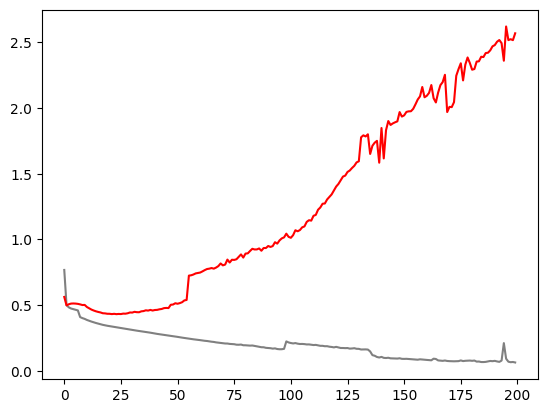

In [69]:
plt.plot(train_history, 'gray')
plt.plot(valid_history, 'r')

### Evaluate Model

In [70]:
# train_pred = model.predict(X_train)
def standardize_output(arr):
    return (1 / (1 + np.e ** (-1 * arr)))

def find_best_prob(pred_prob, actual, display=True):
    best_prob = 0
    best_ratio = np.inf
    prob_interval = 0.05
    with np.errstate(divide='ignore'):
        if display:
            print(
                f"i\t" + 
                f"ratio\t" + 
                f"roc_auc\t" + 
                f"acc\t" + 
                f"conf_matrix" + 
                "\n==================================================="
            )
        for i in np.arange(0, 1.0, prob_interval):
            pred = pred_prob > i
            metrics = get_metrics(pred, actual, display=False)
            
            PLR = metrics[6]
            NLR = metrics[7]
            roc_auc = metrics[8]
            ratio = (PLR + NLR)/2

            if display:
                print(
                    f"{i:.2f}\t" + 
                    f"{ratio:0.3f}\t" + 
                    f"{roc_auc:0.3f}\t" + 
                    f"{((metrics[0] + metrics[3]) / np.sum(metrics[:4]) * 100):.2f}\t" + 
                    f"{metrics[:4]}"
                )

            if (ratio < best_ratio):
                best_ratio = ratio
                best_prob = i
    if display: print(f"Best Threshold: {best_prob:0.2f}")
    return best_prob

In [71]:
valid_pred_prob = model(X_valid_tensor).detach().numpy()[:,0]
# valid_pred_prob = standardize_output(valid_pred_prob)
threshold = find_best_prob(valid_pred_prob, y_valid)
valid_pred = valid_pred_prob > threshold

test_pred_prob = model(X_test_tensor).detach().numpy()[:,0]
# test_pred_prob = standardize_output(test_pred_prob)
test_pred = test_pred_prob > threshold

i	ratio	roc_auc	acc	conf_matrix
0.00	1.654	0.662	47.38	[125, 250, 1, 101]
0.05	1.077	0.668	74.21	[299, 76, 47, 55]
0.10	1.113	0.663	75.05	[306, 69, 50, 52]
0.15	1.126	0.674	76.73	[314, 61, 50, 52]
0.20	1.150	0.666	76.73	[316, 59, 52, 50]
0.25	1.196	0.657	76.94	[320, 55, 55, 47]
0.30	1.230	0.650	76.94	[322, 53, 57, 45]
0.35	1.239	0.655	77.78	[326, 49, 57, 45]
0.40	1.260	0.653	77.99	[328, 47, 58, 44]
0.45	1.260	0.653	77.99	[328, 47, 58, 44]
0.50	1.278	0.648	77.78	[328, 47, 59, 43]
0.55	1.281	0.649	77.99	[329, 46, 59, 43]
0.60	1.377	0.635	77.99	[333, 42, 63, 39]
0.65	1.428	0.625	77.57	[333, 42, 65, 37]
0.70	1.497	0.620	77.78	[336, 39, 67, 35]
0.75	1.580	0.615	78.20	[340, 35, 69, 33]
0.80	1.675	0.611	78.62	[344, 31, 71, 31]
0.85	1.896	0.596	78.62	[348, 27, 75, 27]
0.90	2.218	0.586	79.25	[355, 20, 79, 23]
0.95	3.559	0.547	78.20	[359, 16, 88, 14]
Best Threshold: 0.05


In [72]:
print("Validation:")
get_metrics(valid_pred, y_valid)
print("===========================")
print("Testing:")
get_metrics(test_pred, y_test)

Validation:
Accuracy: 0.7421
tn:  299,  fp:  76,  fn:  47, tp:  55
Precision:			0.41985
Recall:				0.53922
TPR:				0.53922
FPR:				0.79733
Positive likelihood ratio:	0.67627
Negative likelihood ratio:	1.47869
ROC-AUC Score:	0.66827
Testing:
Accuracy: 0.7601
tn:  397,  fp:  101,  fn:  42, tp:  56
Precision:			0.35669
Recall:				0.57143
TPR:				0.57143
FPR:				0.79719
Positive likelihood ratio:	0.71680
Negative likelihood ratio:	1.39508
ROC-AUC Score:	0.68431
